## <b> Bank Customer Churn Prediction </b>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
bank = pd.read_csv('./Bank+Customer+Churn/Bank_Churn.csv')

In [3]:
bank.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
bank.select_dtypes("number").mean()

CustomerId         1.569094e+07
CreditScore        6.505288e+02
Age                3.892180e+01
Tenure             5.012800e+00
Balance            7.648589e+04
NumOfProducts      1.530200e+00
HasCrCard          7.055000e-01
IsActiveMember     5.151000e-01
EstimatedSalary    1.000902e+05
Exited             2.037000e-01
dtype: float64

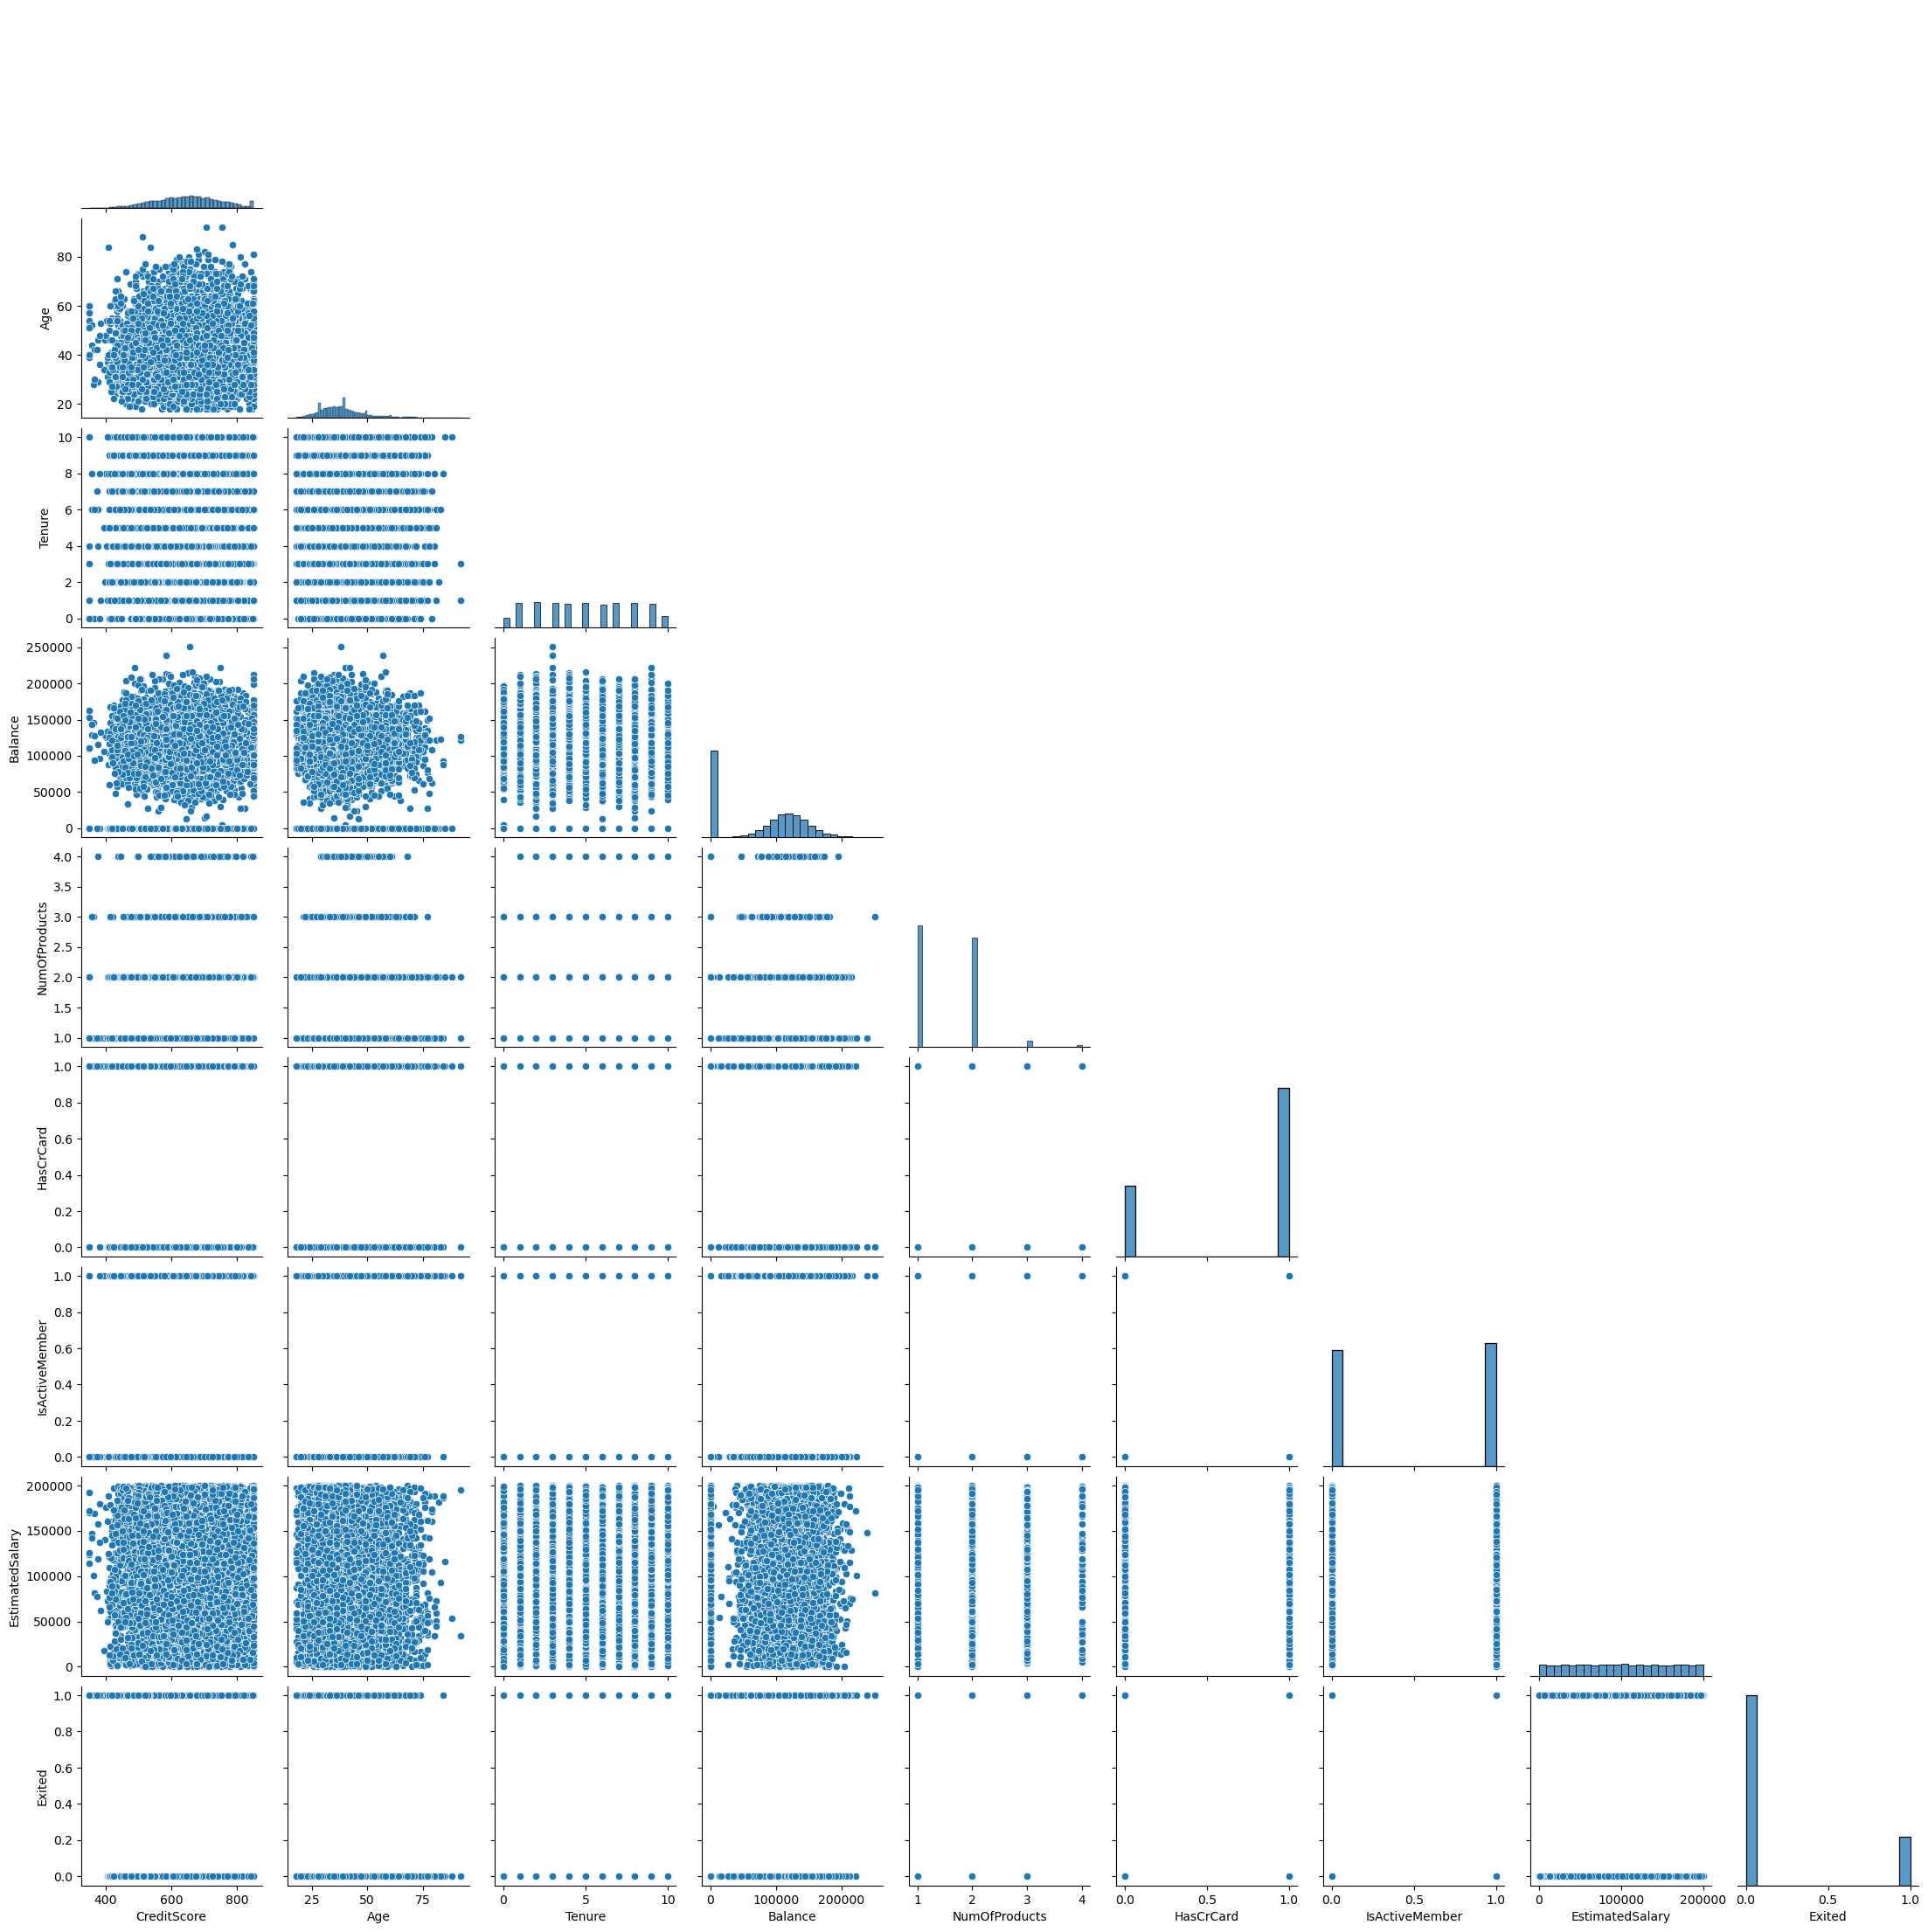

In [5]:
sns.pairplot(
    bank.select_dtypes("number").drop("CustomerId",axis=1),
    corner=True
)

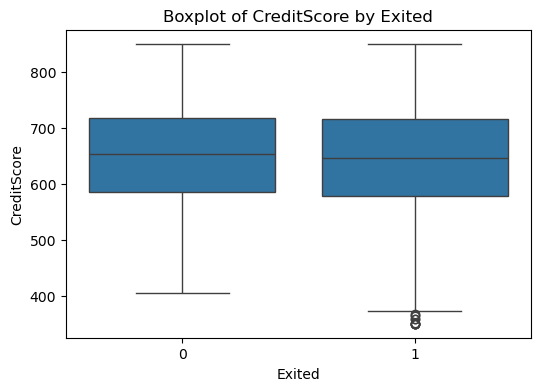

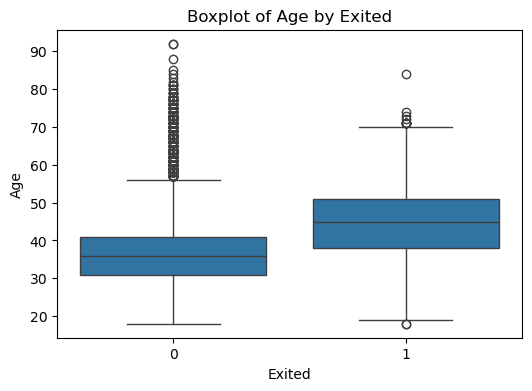

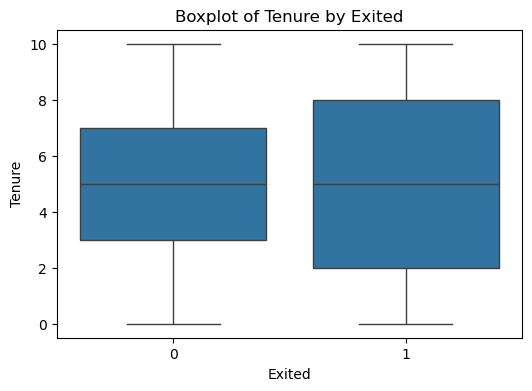

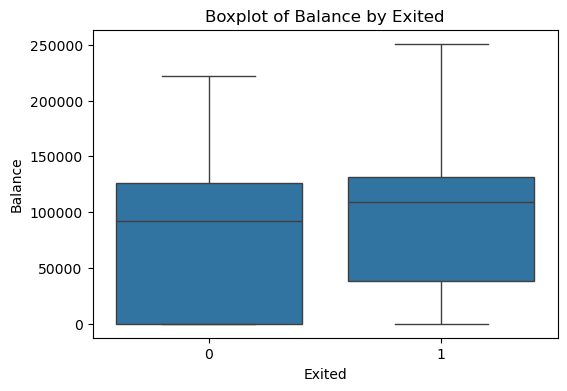

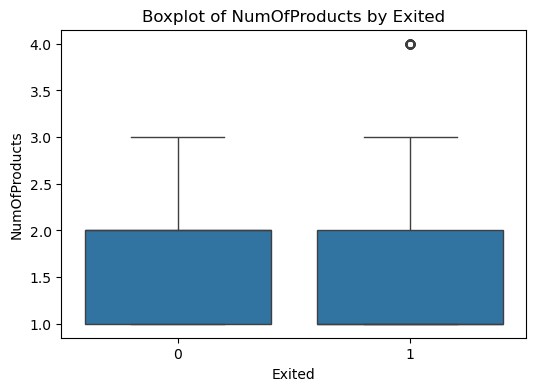

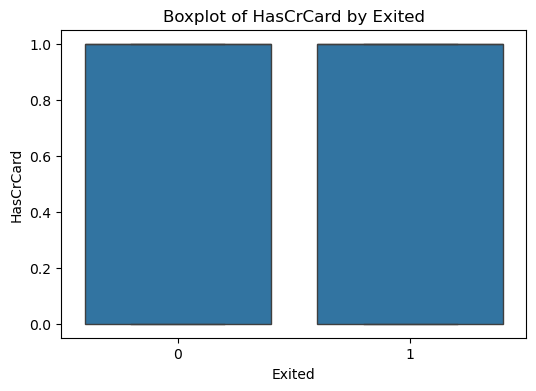

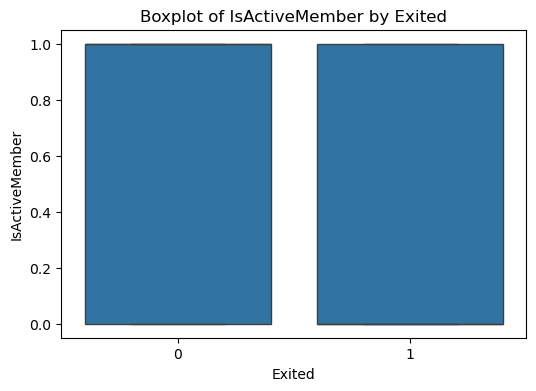

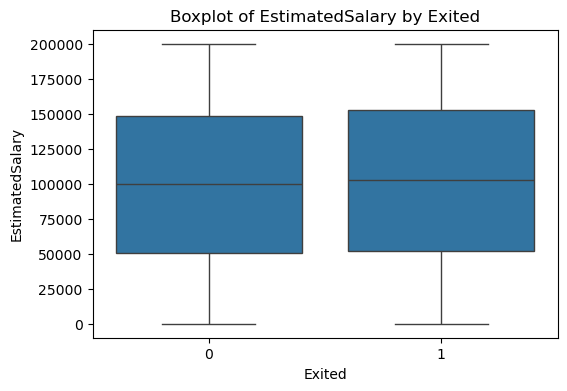

In [6]:
# Select only numeric columns, excluding identifier and target
numeric_cols = bank.select_dtypes(include=['int64', 'float64']).drop(columns=['CustomerId', 'Exited'])

for col in numeric_cols.columns:
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=bank, x='Exited', y=col)
    plt.title(f'Boxplot of {col} by Exited')
    plt.show()

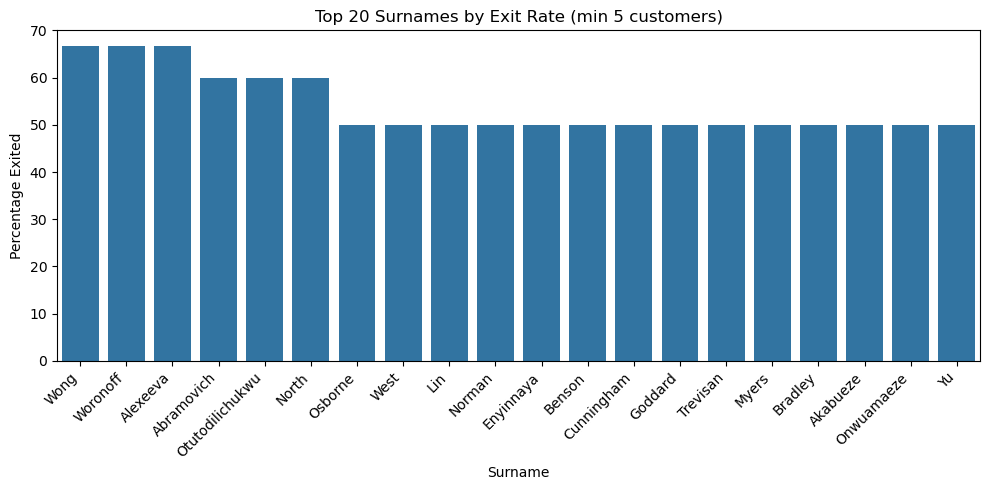

In [7]:
# Only show surnames with at least 5 customers
surname_stats = bank.groupby('Surname')['Exited'].agg(['mean', 'count'])
surname_stats = surname_stats[surname_stats['count'] >= 5]
surname_stats['mean'] *= 100
top_surnames = surname_stats.sort_values('mean', ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x=top_surnames.index, y=top_surnames['mean'])
plt.title('Top 20 Surnames by Exit Rate (min 5 customers)')
plt.ylabel('Percentage Exited')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show();

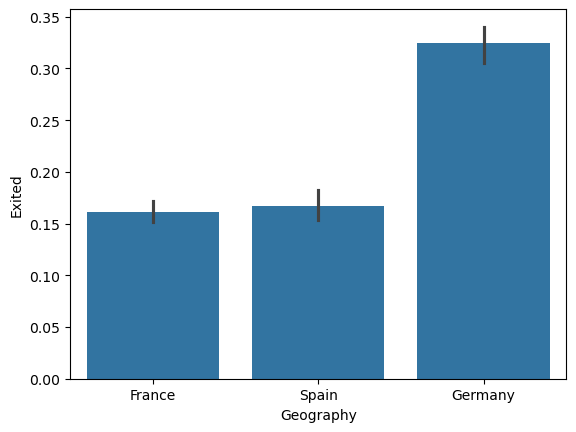

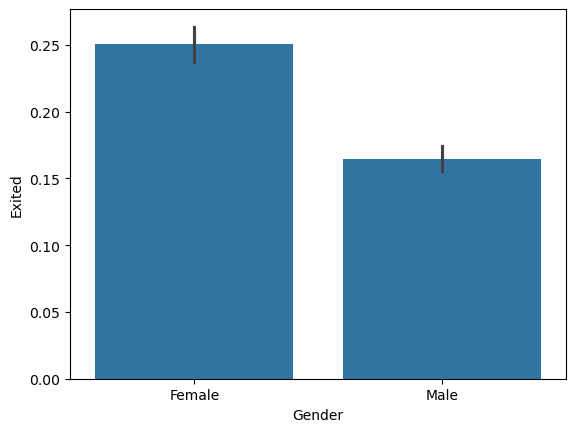

In [8]:
for col in bank.select_dtypes(include="object").columns[1:]:
    sns.barplot(
        data=bank,
        x=col,
        y='Exited'
    )
    plt.show()

In [9]:
## Drop columns not suitable for modelling
bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [10]:
bank.drop(['CustomerId','Surname'],axis=1,inplace=True)

In [11]:
bank.corr(numeric_only=True)["Exited"]

CreditScore       -0.027094
Age                0.285323
Tenure            -0.014001
Balance            0.118533
NumOfProducts     -0.047820
HasCrCard         -0.007138
IsActiveMember    -0.156128
EstimatedSalary    0.012097
Exited             1.000000
Name: Exited, dtype: float64

In [12]:
bank = bank.assign(
    balance_to_income = bank['Balance']/bank['EstimatedSalary'],
    income_v_product = bank['EstimatedSalary']/bank['NumOfProducts']
)

bank = pd.get_dummies(bank,drop_first=True)

In [13]:
bank.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,balance_to_income,income_v_product,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,0.000000,101348.880,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,0.744677,112542.580,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,1.401375,37977.190,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,0.000000,46913.315,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,1.587055,79084.100,False,True,False


In [14]:
## Create feature and target variables
X = bank.drop('Exited',axis=1)
y = bank['Exited']

In [15]:
## Split the dataset into train and test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1024)

In [16]:
X_train.shape

(8000, 13)

In [17]:
## Fit a logistic Regression model on training data
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
                        StandardScaler(),
                        LogisticRegression(max_iter=5000, solver="saga",class_weight="balanced"),
                        verbose=True
                        )

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_test)

[Pipeline] .... (step 1 of 2) Processing standardscaler, total=   0.0s
[Pipeline]  (step 2 of 2) Processing logisticregression, total=   0.2s


In [18]:
## Build a confusion matrix
from sklearn.metrics import (confusion_matrix, accuracy_score, 
                             precision_score, recall_score, f1_score)

confusion_matrix(y_test, preds)

array([[1181,  435],
       [ 120,  264]])

In [19]:
## Calculate accuracy, precision, recall and F1
print(f'Accuracy on train: {accuracy_score(y_train, pipeline.predict(X_train))} ')
print(f'Accuracy on test: {accuracy_score(y_test, preds)}')
print(f'Precision score: {precision_score(y_test, preds)}')
print(f'Recall score: {recall_score(y_test, preds)}')
print(f'F1 score: {f1_score(y_test, preds)}')

Accuracy on train: 0.719 
Accuracy on test: 0.7225
Precision score: 0.3776824034334764
Recall score: 0.6875
F1 score: 0.48753462603878117


In [20]:
y_train.value_counts(normalize=True)

Exited
0    0.793375
1    0.206625
Name: proportion, dtype: float64

In [21]:
#Plot ROC curve and calculate AUC
from sklearn.metrics import roc_curve, auc

probs = pipeline.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, probs)

auc_score = auc(fpr, tpr)


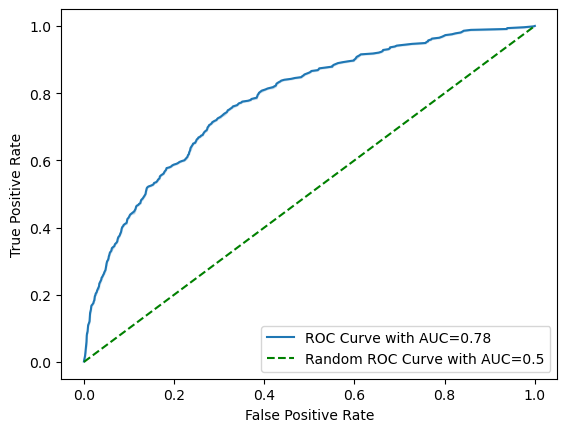

In [22]:
sns.lineplot(x=fpr, y=tpr, label=f'ROC Curve with AUC={auc_score:0.2f}')
sns.lineplot(x=[0,1],y=[0,1], linestyle='--', color='green',
             label='Random ROC Curve with AUC=0.5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();

In [23]:
## Plot precision and recall against the thresholds
from sklearn.metrics import precision_recall_curve

p_curve, r_curve, t_curve = precision_recall_curve(y_train, 
                                                   pipeline.predict_proba(X_train)[:,1])

df = pd.DataFrame({
    'threshold': t_curve,
    'precision': p_curve[:-1],
    'recall': r_curve[:-1]
}
)

df


,threshold,precision,recall
0,0.027796,0.206625,1.000000
1,0.033330,0.206651,1.000000
2,0.033955,0.206677,1.000000
3,0.034277,0.206703,1.000000
4,0.035267,0.206728,1.000000
...,...,...,...
7995,0.986756,0.800000,0.002420
7996,0.987322,0.750000,0.001815
7997,0.989186,1.000000,0.001815
7998,0.997015,1.000000,0.001210


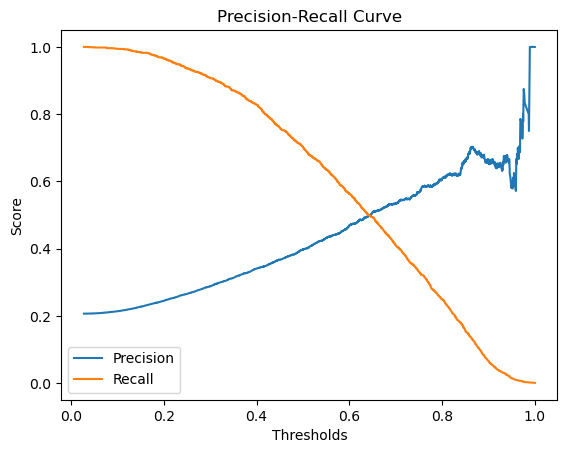

In [24]:
sns.lineplot(x=t_curve,y=p_curve[:-1],label='Precision')
sns.lineplot(x=t_curve, y=r_curve[:-1],label='Recall')
plt.xlabel('Thresholds')
plt.ylabel('Score')
plt.title("Precision-Recall Curve")
plt.show()

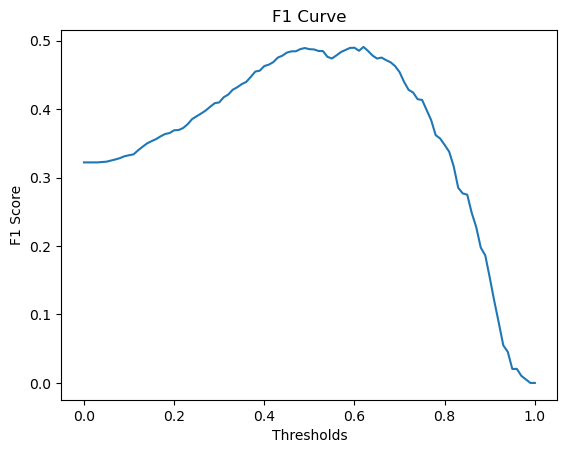

Optimum Threshold: 0.62 with F1 score 0.4908424908424908


In [27]:
## Plot F1 curve
thresholds = np.linspace(0, 1, 101)

pos_preds = pipeline.predict_proba(X_test)[:,1]

f1s = [f1_score(y_test, pos_preds>t) for t in thresholds]

sns.lineplot(x=thresholds, y=f1s)
plt.xlabel('Thresholds')
plt.ylabel('F1 Score')
plt.title('F1 Curve')
plt.show();

thresh = thresholds[np.argmax(f1s)]

print(f'Optimum Threshold: {thresh} with F1 score {max(f1s)}')


In [28]:
custom_preds = (pos_preds > thresh).astype("int")

confusion_matrix(y_test,custom_preds)

array([[1382,  234],
       [ 183,  201]])

In [29]:
print(f'Precision score: {precision_score(y_test, custom_preds)}')
print(f'Recall score: {recall_score(y_test, custom_preds)}')
print(f'F1 score: {f1_score(y_test, custom_preds)}')

Precision score: 0.46206896551724136
Recall score: 0.5234375
F1 score: 0.4908424908424908


In [32]:
## Fit a random forest model with default hyperparameters

from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=1043)
rf.fit(X_train, y_train)

print(f'Train accuracy: {rf.score(X_train, y_train)}')
print(f'Test accuracy: {rf.score(X_test, y_test)}')

Train accuracy: 1.0
Test accuracy: 0.869


In [33]:
confusion_matrix(y_test, rf.predict(X_test))

array([[1559,   57],
       [ 205,  179]])

In [44]:
## use Cross Validation to tune the Random Forest Hyperparameters

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rf = RandomForestClassifier(random_state=1023, n_jobs=-1)

params = {
    'n_estimators': np.arange(100,1100,100),
    'max_features': [None, 'sqrt'],
    'bootstrap': [True],
    'max_samples': [None, 0.3, 0.5, 0.9],
    'max_depth': np.arange(1, 11, 1),
    'min_samples_leaf': [2, 5, 10, 20, 100]
}

grid = RandomizedSearchCV(
    rf,
    param_distributions=params,
    n_iter=100,
    n_jobs=-1,
    scoring='accuracy',
    verbose=True
)

grid.fit(X_train, y_train)
grid.best_params_



Fitting 5 folds for each of 100 candidates, totalling 500 fits


{'n_estimators': np.int64(400),
 'min_samples_leaf': 5,
 'max_samples': 0.3,
 'max_features': None,
 'max_depth': np.int64(9),
 'bootstrap': True}

In [45]:
## Fit the RF model again with the tuned parameters

rf = RandomForestClassifier(**grid.best_params_,random_state=1043)
rf.fit(X_train, y_train)

print(f'Train accuracy: {rf.score(X_train, y_train)}')
print(f'Test accuracy: {rf.score(X_test, y_test)}')

Train accuracy: 0.880125
Test accuracy: 0.866


In [46]:
confusion_matrix(y_test, rf.predict(X_test))

array([[1559,   57],
       [ 211,  173]])

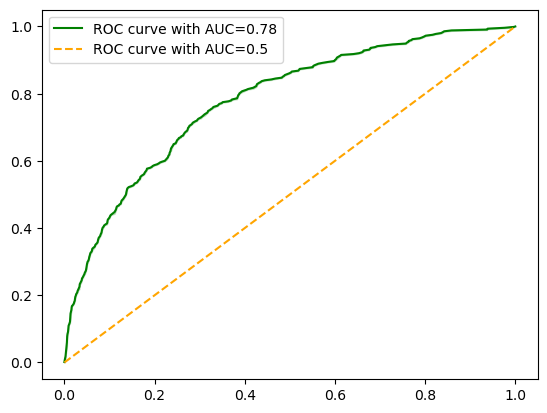

In [47]:
## Generate ROC-AUC curve for the tuned model

preds = rf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc_score = auc(fpr, tpr)

sns.lineplot(x=fpr, y=tpr, linestyle='-', 
             color='green', label=f'ROC curve with AUC={auc_score:0.2f}')
sns.lineplot(x=[0,1],y=[0,1],linestyle='--', color='orange', label='ROC curve with AUC=0.5')
plt.show();

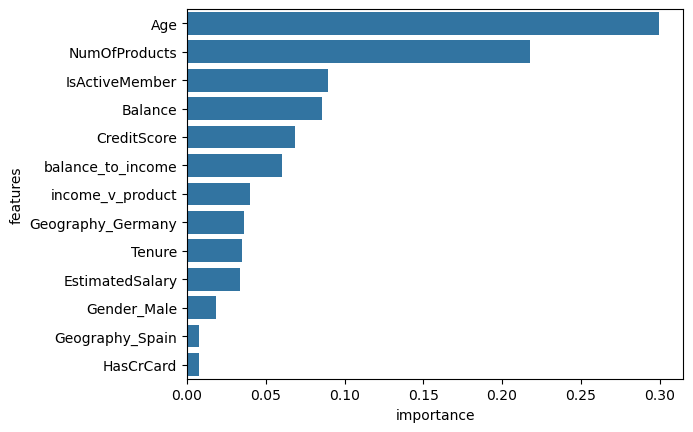

In [48]:
## Bar plot with feature persformance

df = pd.DataFrame({'features': X_test.columns, 
                   'importance':rf.feature_importances_}).sort_values('importance',ascending=False)

sns.barplot(data=df, x='importance', y='features')
plt.show();

In [55]:
print(f'{bank['balance_to_income'].mean():0.2f}')

3.88


Exception ignored in: <function ResourceTracker.__del__ at 0x10ef6b2e0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyterlab-debugger/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/jupyterlab-debugger/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/jupyterlab-debugger/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x110dff2e0>
Traceback (most recent call last):
  File "/opt/anaconda3/envs/jupyterlab-debugger/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/envs/jupyterlab-debugger/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/envs/jupyterlab-debugger/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
Chi